##                                                      PREDICTING LOAN PAYBACK

This project is a kaggle competition task which is aim at using a loan dataset to predict if loan applicants will pay back their loans after thier applications are granted. 

This project includes Preliminary Data Analysis (PDA), Exploratory Data Analysis (EDA), Data Preprocessing and Model Training and Report. 

The outcome of my model prediction will be submitted on Kaggle for assessment as part of requirement for the competition.

1- Library Importation

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

In [316]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler

In [317]:
# Data importation

# zip_path = r"C:\Users\ncc\Desktop\ML_Datasets\playground-series-s5e11.zip"
zip_path = r"C:\Users\Osisami\Desktop\ML_Datasets\playground-series-s5e11.zip"



with ZipFile(zip_path, "r") as zip_ref:
    zip_ref.printdir()


with ZipFile(zip_path, "r") as zip_data:
    with zip_data.open("train.csv") as f:
        loan_data= pd.read_csv(f, sep=",")
    

File Name                                             Modified             Size
sample_submission.csv                          2025-10-28 23:08:48      2291139
test.csv                                       2025-10-28 23:08:48     23021430
train.csv                                      2025-10-28 23:08:50     55988519


2- Preliminary Data Analysis

In [318]:
df = loan_data.copy()
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [319]:
df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


## 3- Data Cleaning

Checking Missing Data

In [321]:
df.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

From the above, there is no missing data in the training dataset

Checking Data Duplicates

In [322]:
# Check for missing values 
print("\n Missing Values:")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found")


 Missing Values:
No missing values found


From the above, there is no duplicated data. therefore, we can proceed to Exploratory Data Analysis

## Exploratory Data Analysis

Univariate Numerical Analysis- 

In [323]:
# Performing Univariate Analysis
def univariate_numerical_eda(data, column):
    """
    Performs univariate EDA on a single numerical column
    displays summary statistics, skewness, kurtosis, histogram, KDE, and boxplot.
    """
    print(f"Feature: {column}")
    print("*"*40)
    print(data[column].describe().to_frame())
    print(f"Skweness: {data[column].skew():.3f}")
    print(f"Kurtosis: {df[column].kurt():.3f}")

    plt.figure(figsize=(12,4))

    # Histogram + KDE
    plt.subplot(1,2,1)
    sns.histplot(df[column], kde=True, bins=30, color='teal')
    plt.title(f'\n Distribution of {column}', fontsize=13)
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[column], color='teal')
    plt.title(f'\n Boxplot of {column}', fontsize=13)

    plt.tight_layout()
    plt.show()

    # Optional note on transformation
    if abs(df[column].skew()) > 1:
        print(f"\n {column} is highly skewed. Consider log or Box-Cox transformation.")
    elif abs(df[column].skew()) > 0.5:
        print(f"{column} is moderately skewed.")
    else:
        print(f"{column} is fairly symmetric.")

In [324]:
# idenifying the numerical columns
num_cols = df.select_dtypes(include=["number"])
num_cols.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'loan_paid_back'],
      dtype='object')

Feature: id
****************************************
                  id
count  593994.000000
mean   296996.500000
std    171471.442236
min         0.000000
25%    148498.250000
50%    296996.500000
75%    445494.750000
max    593993.000000
Skweness: 0.000
Kurtosis: -1.200


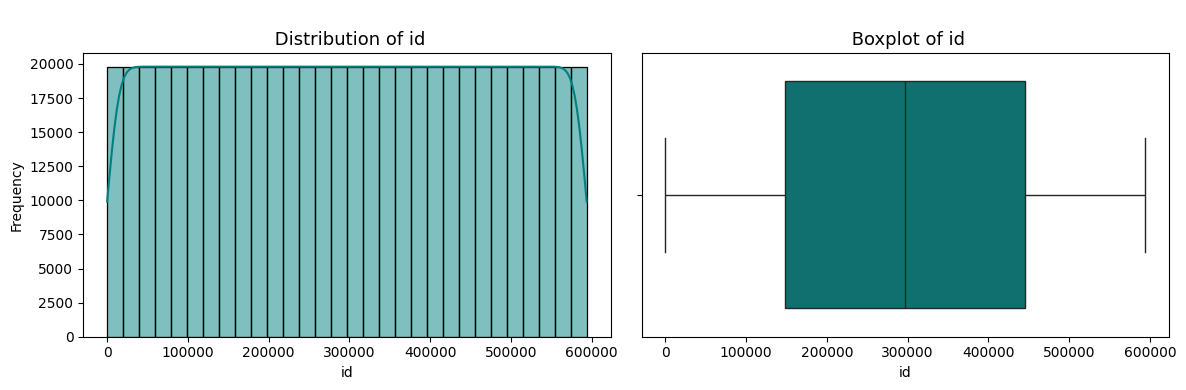

id is fairly symmetric.
Feature: annual_income
****************************************
       annual_income
count  593994.000000
mean    48212.202976
std     26711.942078
min      6002.430000
25%     27934.400000
50%     46557.680000
75%     60981.320000
max    393381.740000
Skweness: 1.720
Kurtosis: 7.091


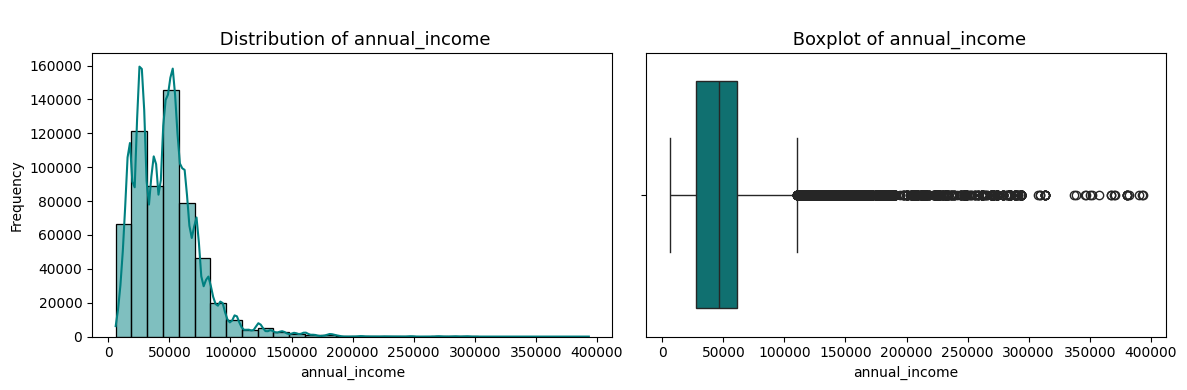


 annual_income is highly skewed. Consider log or Box-Cox transformation.
Feature: debt_to_income_ratio
****************************************
       debt_to_income_ratio
count         593994.000000
mean               0.120696
std                0.068573
min                0.011000
25%                0.072000
50%                0.096000
75%                0.156000
max                0.627000
Skweness: 1.407
Kurtosis: 2.335


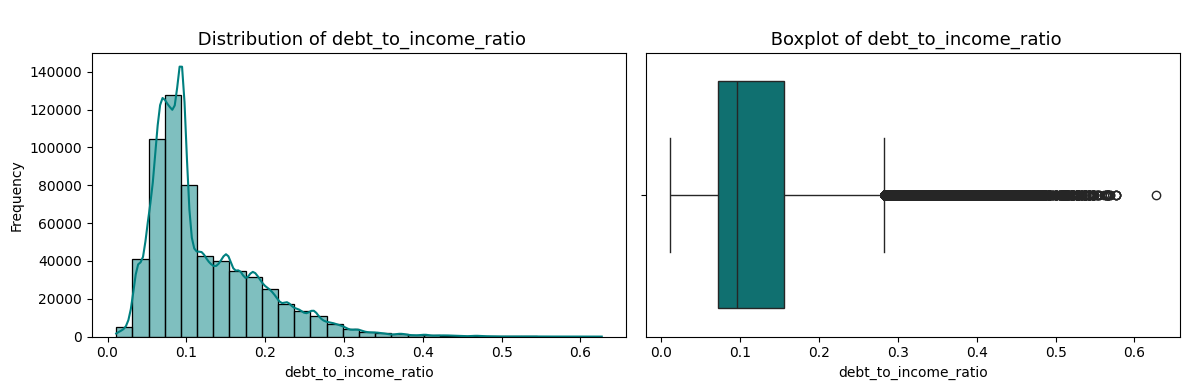


 debt_to_income_ratio is highly skewed. Consider log or Box-Cox transformation.
Feature: credit_score
****************************************
        credit_score
count  593994.000000
mean      680.916009
std        55.424956
min       395.000000
25%       646.000000
50%       682.000000
75%       719.000000
max       849.000000
Skweness: -0.167
Kurtosis: 0.096


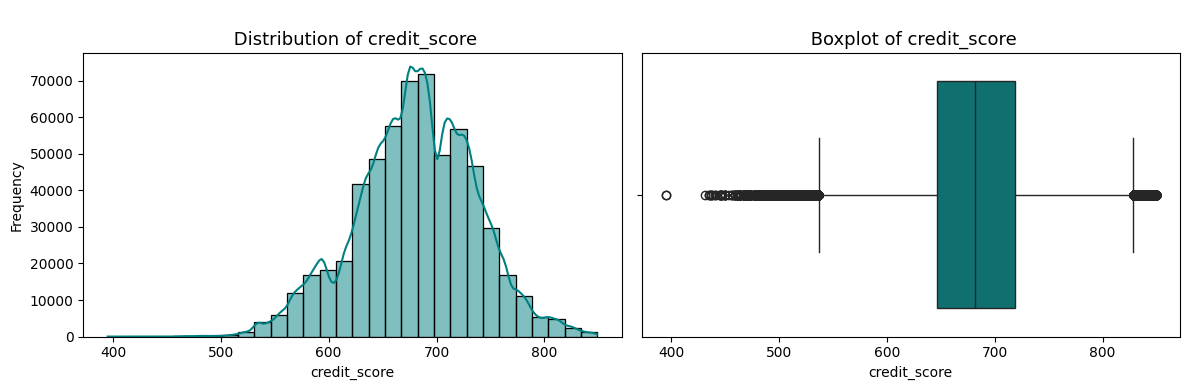

credit_score is fairly symmetric.
Feature: loan_amount
****************************************
         loan_amount
count  593994.000000
mean    15020.297629
std      6926.530568
min       500.090000
25%     10279.620000
50%     15000.220000
75%     18858.580000
max     48959.950000
Skweness: 0.207
Kurtosis: -0.150


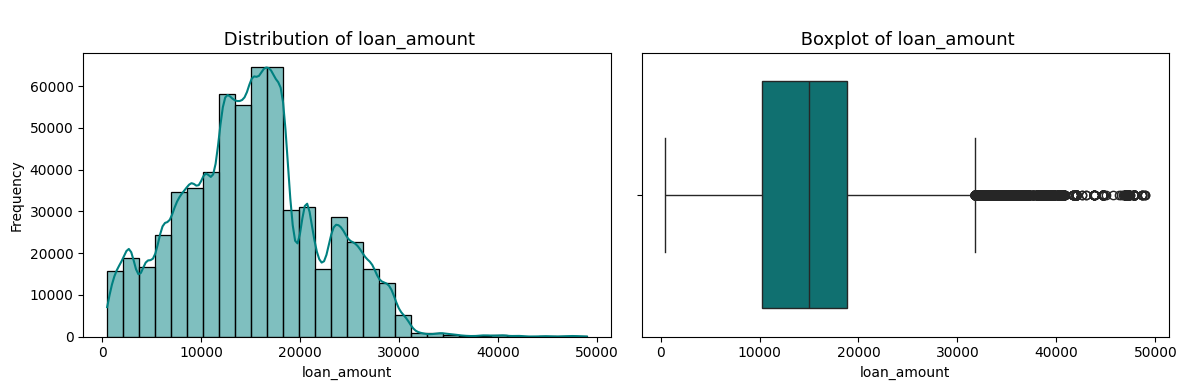

loan_amount is fairly symmetric.
Feature: interest_rate
****************************************
       interest_rate
count  593994.000000
mean       12.356345
std         2.008959
min         3.200000
25%        10.990000
50%        12.370000
75%        13.680000
max        20.990000
Skweness: 0.050
Kurtosis: 0.060


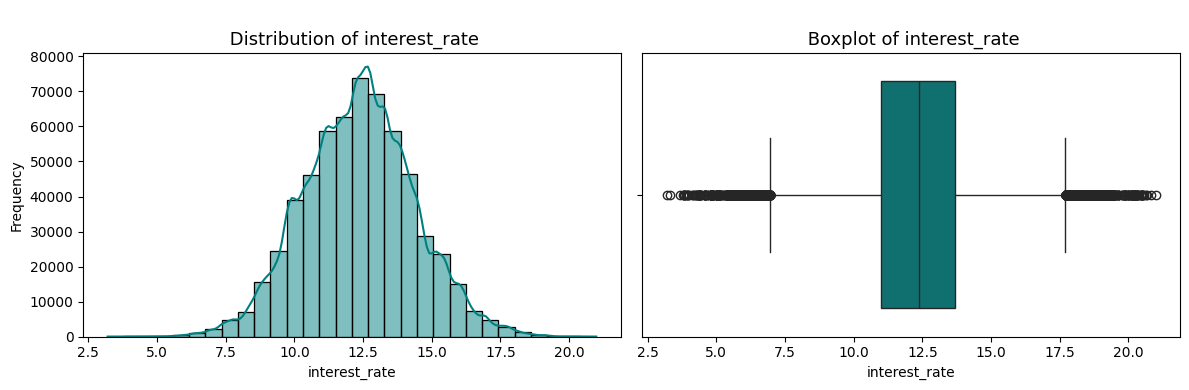

interest_rate is fairly symmetric.
Feature: loan_paid_back
****************************************
       loan_paid_back
count   593994.000000
mean         0.798820
std          0.400883
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Skweness: -1.491
Kurtosis: 0.223


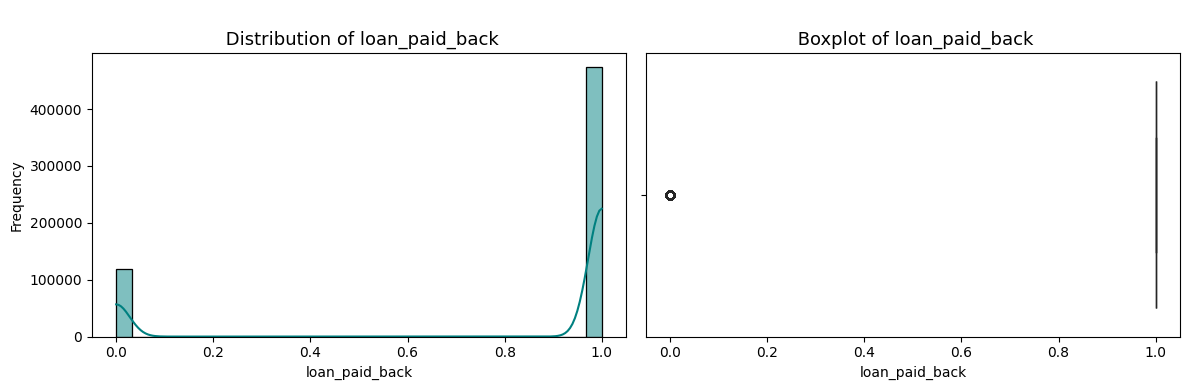


 loan_paid_back is highly skewed. Consider log or Box-Cox transformation.


In [325]:
# applying numerica functions on the cols 
for col in num_cols:
    univariate_numerical_eda(df, col)

Univariate Analysis Report

|Feature         |Distribution          |Outlier            |Spread         |
|----------------|----------------------|-------------------|---------------|


Recommedation: Np.log for Annual income and loan_income_ratio beacuse they are higly skewed. 

Recommendation: For ouliers, leave them as they are also passing an information 

## Univariate Categorical Analysis

In [326]:
def univariate_categorical_eda(data, column):
    """
    Performs univariate EDA on a categorical or ordinal column.
    Displays frequency table, proportion, and a countplot.
    """
    print(f"Feature: {column}")
    print("*"*40)

    # Frequency + proportion
    freq = data[column].value_counts()
    prop = data[column].value_counts(normalize=True) * 100
    summary = pd.DataFrame({'Count': freq, 'Percentage': prop.round(2)})
    print(summary)
    print()

    # Visualization
    plt.figure(figsize=(12,4))

    # Bar chart
    plt.subplot(1,2,1)
    ax = sns.countplot(x=column, data=data, palette='Set2', order=freq.index,color='teal')
    plt.title(f'Distribution of {column}', fontsize=13)
    plt.xlabel(column)
    plt.ylabel('Count')

    # Annotate each bar with percentage
    total = len(data[column])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + 1,
                f'{(height/total)*100:.1f}%', ha='center')

    # Piechart
    plt.subplot(1,2,2)
    plt.pie(freq, labels=freq.index, autopct="%1.1f%%")

    plt.tight_layout()
    plt.show()

In [327]:
# Selecting categorical columns

cat_cols = df.select_dtypes(include=["object"]).columns
cat_cols 


Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')

Feature: gender
****************************************
         Count  Percentage
gender                    
Female  306175       51.55
Male    284091       47.83
Other     3728        0.63



C:\Users\Osisami\AppData\Local\Temp\ipykernel_3608\3810989115.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data, palette='Set2', order=freq.index,color='teal')


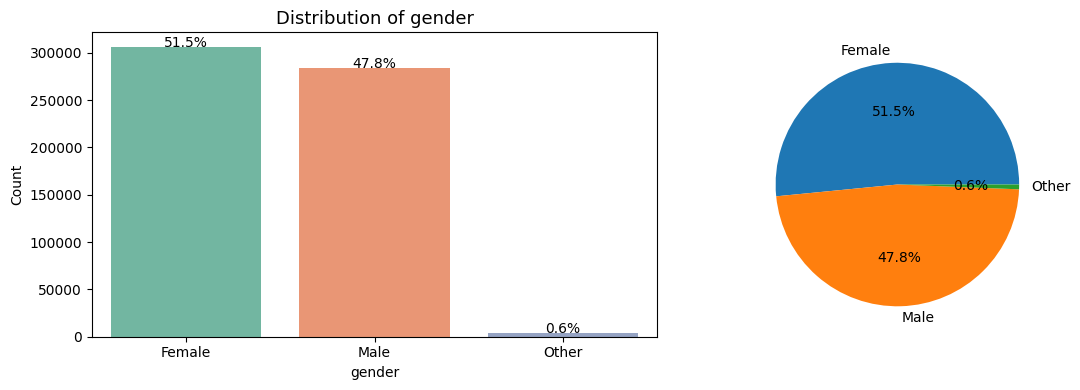

Feature: marital_status
****************************************
                 Count  Percentage
marital_status                    
Single          288843       48.63
Married         277239       46.67
Divorced         21312        3.59
Widowed           6600        1.11



C:\Users\Osisami\AppData\Local\Temp\ipykernel_3608\3810989115.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data, palette='Set2', order=freq.index,color='teal')


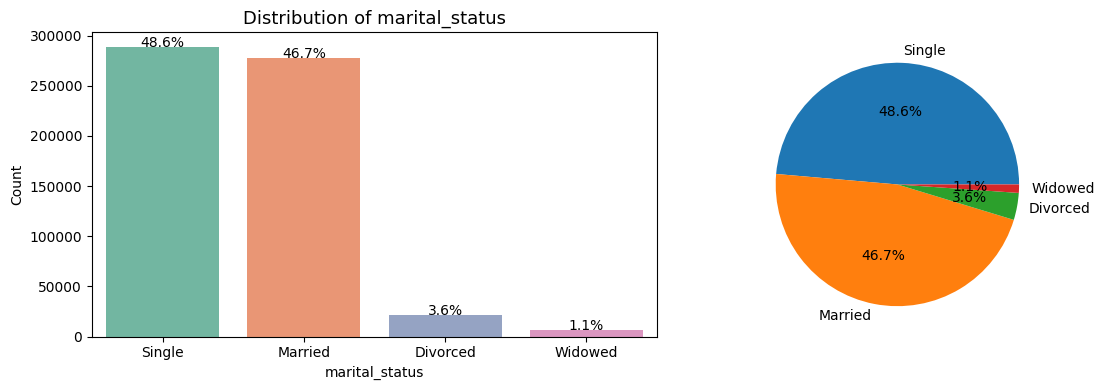

Feature: education_level
****************************************
                  Count  Percentage
education_level                    
Bachelor's       279606       47.07
High School      183592       30.91
Master's          93097       15.67
Other             26677        4.49
PhD               11022        1.86



C:\Users\Osisami\AppData\Local\Temp\ipykernel_3608\3810989115.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data, palette='Set2', order=freq.index,color='teal')


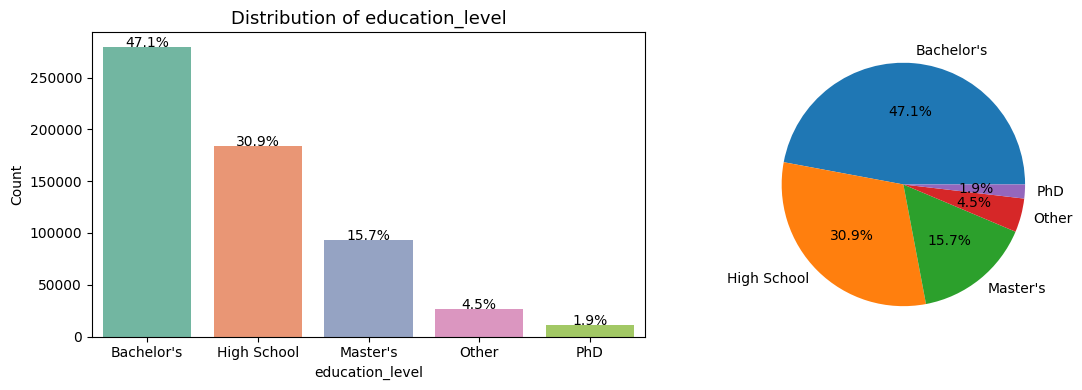

Feature: employment_status
****************************************
                    Count  Percentage
employment_status                    
Employed           450645       75.87
Unemployed          62485       10.52
Self-employed       52480        8.84
Retired             16453        2.77
Student             11931        2.01



C:\Users\Osisami\AppData\Local\Temp\ipykernel_3608\3810989115.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data, palette='Set2', order=freq.index,color='teal')


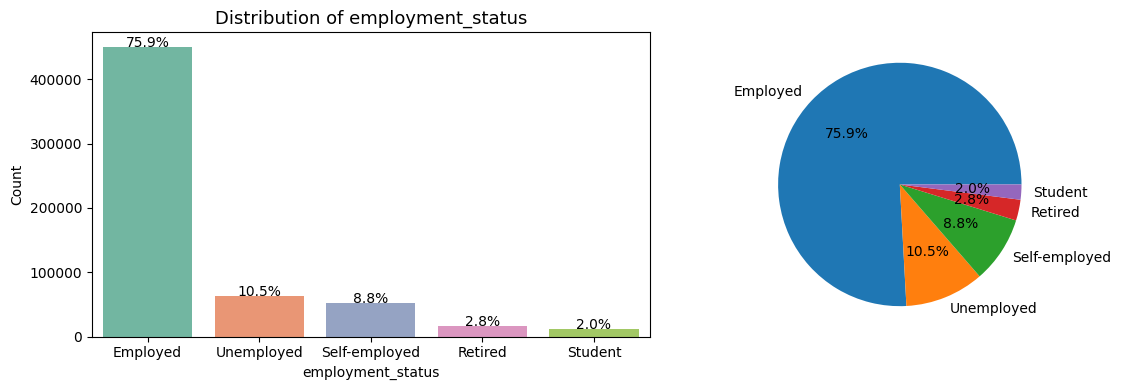

Feature: loan_purpose
****************************************
                     Count  Percentage
loan_purpose                          
Debt consolidation  324695       54.66
Other                63874       10.75
Car                  58108        9.78
Home                 44118        7.43
Education            36641        6.17
Business             35303        5.94
Medical              22806        3.84
Vacation              8449        1.42



C:\Users\Osisami\AppData\Local\Temp\ipykernel_3608\3810989115.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data, palette='Set2', order=freq.index,color='teal')


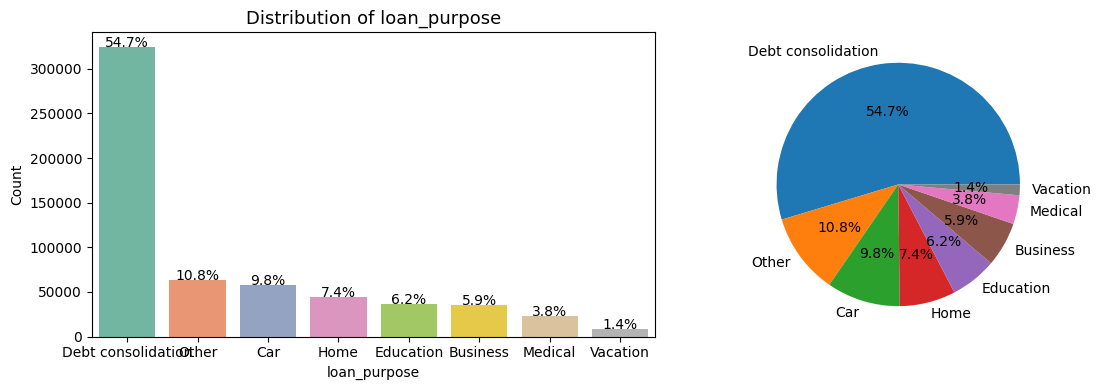

Feature: grade_subgrade
****************************************
                Count  Percentage
grade_subgrade                   
C3              58695        9.88
C4              55957        9.42
C2              54443        9.17
C1              53363        8.98
C5              53317        8.98
D1              37029        6.23
D3              36694        6.18
D4              35097        5.91
D2              34432        5.80
D5              32101        5.40
B2              15167        2.55
B1              14344        2.41
B5              13937        2.35
B3              13926        2.34
B4              13877        2.34
E4               8036        1.35
E3               7075        1.19
E1               6891        1.16
E2               6372        1.07
E5               6084        1.02
F5               5947        1.00
F4               5535        0.93
F1               5534        0.93
F2               5203        0.88
F3               5082        0.86
A5               

C:\Users\Osisami\AppData\Local\Temp\ipykernel_3608\3810989115.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data, palette='Set2', order=freq.index,color='teal')


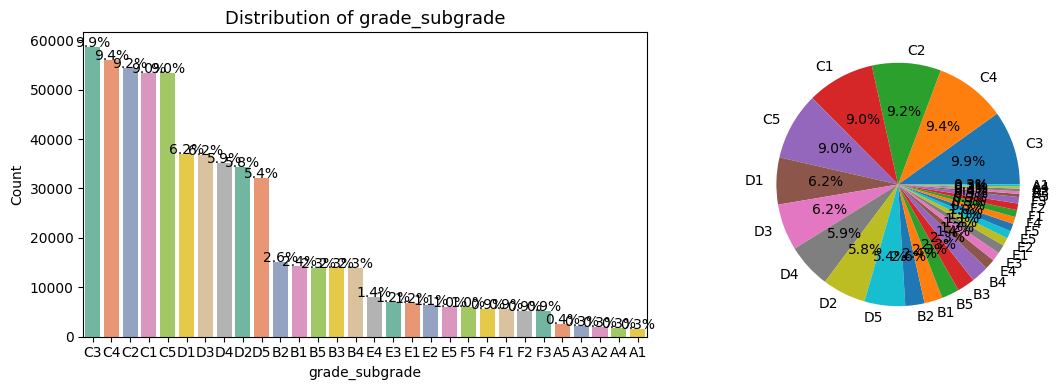

In [328]:
for col in cat_cols:
    univariate_categorical_eda(df, col)

Handling Skewed Feature

In [329]:
df.head(1)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0


In [330]:
# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# 3. Check skewness for variables identified in EDA as right-skewed
print("\n Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ['annual_income', 'debt_to_income_ratio']
for var in skewed_vars:
    if var in df.columns:
        skewness = skew(df[var])
        print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")



 Skewness Analysis (EDA identified right-skewed variables):
annual_income: skewness = 1.720 (right-skewed)
debt_to_income_ratio: skewness = 1.407 (right-skewed)


In [331]:
df['annual_income'] = np.log(df['annual_income'])
df["debt_to_income_ratio"] = np.log(df["debt_to_income_ratio"])

In [332]:
# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Check skewness for variables identified in EDA as right-skewed
print("\n Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ['annual_income', 'debt_to_income_ratio']
for var in skewed_vars:
    if var in df.columns:
        skewness = skew(df[var])
        print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")


 Skewness Analysis (EDA identified right-skewed variables):
annual_income: skewness = -0.342 (approximately normal)
debt_to_income_ratio: skewness = 0.081 (approximately normal)


Conversion of Categorical cOLUMNS TO nUMERICAL

In [333]:
cat_cols = df.select_dtypes(include=["object"])
cat_cols 

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,Female,Single,High School,Self-employed,Other,C3
1,Male,Married,Master's,Employed,Debt consolidation,D3
2,Male,Single,High School,Employed,Debt consolidation,C5
3,Female,Single,High School,Employed,Debt consolidation,F1
4,Male,Married,High School,Employed,Other,D1
...,...,...,...,...,...,...
593989,Female,Single,High School,Employed,Business,C3
593990,Male,Single,Bachelor's,Employed,Debt consolidation,F5
593991,Female,Married,Bachelor's,Employed,Debt consolidation,C1
593992,Male,Single,Bachelor's,Employed,Debt consolidation,B2


In [334]:
df.head(1)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,10.287661,-2.476938,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0


Encoding 
In this analysis, bivariate analysis might not be needed. We just need to encode the categorical columns, scale the whole dataset except loan_paid_back which we will convert to categorical feature to grade payability or NON-payability.

Action Point: First check the value counts of each categorical cols then hot encode or label encode

In [335]:
cat_cols.head(1)

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,Female,Single,High School,Self-employed,Other,C3


In [336]:
df["gender"].value_counts()

gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64

In [337]:
# df["gender"] = df["gender"].map({"Female"})

df = pd.get_dummies(df, columns=["gender"], prefix="gender", dtype=int)

df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,gender_Female,gender_Male,gender_Other
0,0,10.287661,-2.476938,736,2528.42,13.67,Single,High School,Self-employed,Other,C3,1.0,1,0,0
1,1,10.003696,-1.795767,636,4593.10,12.92,Married,Master's,Employed,Debt consolidation,D3,0.0,0,1,0
2,2,10.811064,-2.333044,694,17005.15,9.76,Single,High School,Employed,Debt consolidation,C5,1.0,0,1,0
3,3,10.754882,-2.733368,533,4682.48,16.10,Single,High School,Employed,Debt consolidation,F1,1.0,1,0,0
4,4,10.146304,-2.937463,665,12184.43,10.21,Married,High School,Employed,Other,D1,1.0,0,1,0


In [338]:
# df.drop(columns=["id"], inplace=True)
df.head(1)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,gender_Female,gender_Male,gender_Other
0,0,10.287661,-2.476938,736,2528.42,13.67,Single,High School,Self-employed,Other,C3,1.0,1,0,0


In [339]:
# Label Encoding Marital Status
print(df["marital_status"].value_counts())
df = pd.get_dummies(df, columns=["marital_status"], dtype=int)

df.head()

marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,gender_Female,gender_Male,gender_Other,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Widowed
0,0,10.287661,-2.476938,736,2528.42,13.67,High School,Self-employed,Other,C3,1.0,1,0,0,0,0,1,0
1,1,10.003696,-1.795767,636,4593.10,12.92,Master's,Employed,Debt consolidation,D3,0.0,0,1,0,0,1,0,0
2,2,10.811064,-2.333044,694,17005.15,9.76,High School,Employed,Debt consolidation,C5,1.0,0,1,0,0,0,1,0
3,3,10.754882,-2.733368,533,4682.48,16.10,High School,Employed,Debt consolidation,F1,1.0,1,0,0,0,0,1,0
4,4,10.146304,-2.937463,665,12184.43,10.21,High School,Employed,Other,D1,1.0,0,1,0,0,1,0,0


In [340]:
# Label Encoding Educational Status
print(df["education_level"].value_counts())
df = pd.get_dummies(df, columns=["education_level"], dtype=int)

df.head()

education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,employment_status,loan_purpose,grade_subgrade,loan_paid_back,...,gender_Other,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Widowed,education_level_Bachelor's,education_level_High School,education_level_Master's,education_level_Other,education_level_PhD
0,0,10.287661,-2.476938,736,2528.42,13.67,Self-employed,Other,C3,1.0,...,0,0,0,1,0,0,1,0,0,0
1,1,10.003696,-1.795767,636,4593.10,12.92,Employed,Debt consolidation,D3,0.0,...,0,0,1,0,0,0,0,1,0,0
2,2,10.811064,-2.333044,694,17005.15,9.76,Employed,Debt consolidation,C5,1.0,...,0,0,0,1,0,0,1,0,0,0
3,3,10.754882,-2.733368,533,4682.48,16.10,Employed,Debt consolidation,F1,1.0,...,0,0,0,1,0,0,1,0,0,0
4,4,10.146304,-2.937463,665,12184.43,10.21,Employed,Other,D1,1.0,...,0,0,1,0,0,0,1,0,0,0


In [341]:
# Label Encoding  Loan purpose
print(df["loan_purpose"].value_counts())
df = pd.get_dummies(df, columns=["loan_purpose"], dtype=int)

df.head()

loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business               35303
Medical                22806
Vacation                8449
Name: count, dtype: int64


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,employment_status,grade_subgrade,loan_paid_back,gender_Female,...,education_level_Other,education_level_PhD,loan_purpose_Business,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
0,0,10.287661,-2.476938,736,2528.42,13.67,Self-employed,C3,1.0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,10.003696,-1.795767,636,4593.10,12.92,Employed,D3,0.0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,10.811064,-2.333044,694,17005.15,9.76,Employed,C5,1.0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,10.754882,-2.733368,533,4682.48,16.10,Employed,F1,1.0,1,...,0,0,0,0,1,0,0,0,0,0
4,4,10.146304,-2.937463,665,12184.43,10.21,Employed,D1,1.0,0,...,0,0,0,0,0,0,0,0,1,0


In [342]:
# Label Encoding  Employment_status
print(df["employment_status"].value_counts())
df = pd.get_dummies(df, columns=["employment_status"], dtype=int)

df.head()

employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,grade_subgrade,loan_paid_back,gender_Female,gender_Male,...,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed
0,0,10.287661,-2.476938,736,2528.42,13.67,C3,1.0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,1,10.003696,-1.795767,636,4593.10,12.92,D3,0.0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,10.811064,-2.333044,694,17005.15,9.76,C5,1.0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,10.754882,-2.733368,533,4682.48,16.10,F1,1.0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,4,10.146304,-2.937463,665,12184.43,10.21,D1,1.0,0,1,...,0,0,0,1,0,1,0,0,0,0


In [343]:
# Handling grade_subgrade
df["grade_subgrade"].value_counts()

grade_subgrade
C3    58695
C4    55957
C2    54443
C1    53363
C5    53317
D1    37029
D3    36694
D4    35097
D2    34432
D5    32101
B2    15167
B1    14344
B5    13937
B3    13926
B4    13877
E4     8036
E3     7075
E1     6891
E2     6372
E5     6084
F5     5947
F4     5535
F1     5534
F2     5203
F3     5082
A5     2471
A3     2066
A2     2018
A4     1701
A1     1600
Name: count, dtype: int64

From the above, we have different letters showing how risky approving a loan is. In this work, 

the grades will be streamlined to just seven alphabets A-G where A & B is low risk, 

C & D is medium risk while the rest will be highly risky. 

In [344]:
# Step 1 — Extract the grade letter
df['grade'] = df['grade_subgrade'].str[0]

# Step 2 — Create a mapping dictionary

risk_map = {
    'A': 'Low',
    'B': 'Low',
    'C': 'Medium',
    'D': 'Medium',
    'E': 'High',
    'F': 'High',
    'G': 'High'
}

# Step 3 — Map to risk level
df['grade_risk'] = df['grade'].map(risk_map)

# Step 4. One-hot encode the simplified classes
df = pd.get_dummies(df, columns=['grade_risk'], dtype=int)

In [345]:
df.drop(columns=["grade_subgrade"], inplace=True)

In [346]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back,gender_Female,gender_Male,gender_Other,...,loan_purpose_Vacation,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,grade,grade_risk_High,grade_risk_Low,grade_risk_Medium
0,0,10.287661,-2.476938,736,2528.42,13.67,1.0,1,0,0,...,0,0,0,1,0,0,C,0,0,1
1,1,10.003696,-1.795767,636,4593.10,12.92,0.0,0,1,0,...,0,1,0,0,0,0,D,0,0,1
2,2,10.811064,-2.333044,694,17005.15,9.76,1.0,0,1,0,...,0,1,0,0,0,0,C,0,0,1
3,3,10.754882,-2.733368,533,4682.48,16.10,1.0,1,0,0,...,0,1,0,0,0,0,F,1,0,0
4,4,10.146304,-2.937463,665,12184.43,10.21,1.0,0,1,0,...,0,1,0,0,0,0,D,0,0,1


In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               593994 non-null  int64  
 1   annual_income                    593994 non-null  float64
 2   debt_to_income_ratio             593994 non-null  float64
 3   credit_score                     593994 non-null  int64  
 4   loan_amount                      593994 non-null  float64
 5   interest_rate                    593994 non-null  float64
 6   loan_paid_back                   593994 non-null  float64
 7   gender_Female                    593994 non-null  int64  
 8   gender_Male                      593994 non-null  int64  
 9   gender_Other                     593994 non-null  int64  
 10  marital_status_Divorced          593994 non-null  int64  
 11  marital_status_Married           593994 non-null  int64  
 12  ma

In [348]:
# Correlation of each features with the target variable

def correlation_with_target(df, target_col, figsize=(15,2)):
    """
    Plots a heatmap showing correlation of each numeric feature against target_col.
    Returns a Series of correlations (sorted by absolute magnitude).
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include='number').copy()
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric and present in the dataframe.")

    # compute correlations of every numeric column with the target
    corrs = numeric_df.corrwith(numeric_df[target_col]).drop(target_col)

    corrs_df = corrs.to_frame(name='corr').T  # shape (1, n)

    plt.figure(figsize=figsize)
    sns.heatmap(
        corrs_df,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={'orientation': 'vertical', 'shrink':0.7}
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks([0], [target_col], rotation=0)
    plt.title(f'Correlation of numeric features with {target_col}', fontsize=12)
    plt.tight_layout()
    plt.show()

    # return sorted correlations for downstream use
    return corrs

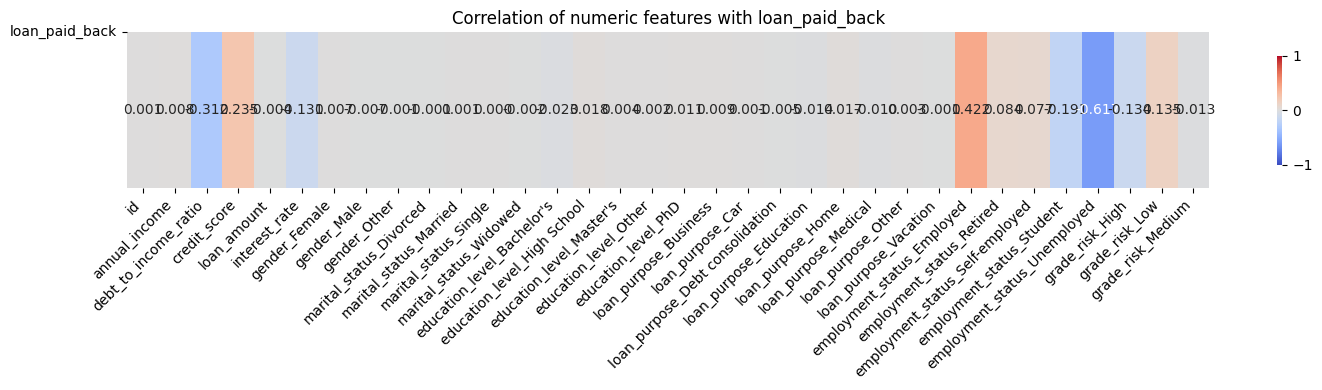

id                                 0.001387
annual_income                      0.008248
debt_to_income_ratio              -0.312002
credit_score                       0.234560
loan_amount                       -0.003762
interest_rate                     -0.131184
gender_Female                      0.007432
gender_Male                       -0.007326
gender_Other                      -0.000691
marital_status_Divorced           -0.001049
marital_status_Married             0.000758
marital_status_Single              0.000131
marital_status_Widowed            -0.002372
education_level_Bachelor's        -0.023354
education_level_High School        0.018149
education_level_Master's           0.003792
education_level_Other              0.002147
education_level_PhD                0.010718
loan_purpose_Business              0.008957
loan_purpose_Car                   0.001487
loan_purpose_Debt consolidation   -0.005228
loan_purpose_Education            -0.013922
loan_purpose_Home               

In [349]:
correlation_with_target(df, target_col="loan_paid_back", figsize=(15,4))

In [350]:
# Handling our target class - LoAN PAID BACK

# df["loan_paid_back"] = df["loan_paid_back"].map({1.0 : "REPAID", 0.0 : "DEFAULT"})
# df["loan_paid_back"].head()

## FEATURE ENGINEERING

In [351]:
df.head(1)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back,gender_Female,gender_Male,gender_Other,...,loan_purpose_Vacation,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,grade,grade_risk_High,grade_risk_Low,grade_risk_Medium
0,0,10.287661,-2.476938,736,2528.42,13.67,1.0,1,0,0,...,0,0,0,1,0,0,C,0,0,1


In [352]:
# Loan-to-Income Ratio:
# creating  loan to income ratio

df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']


# Credit score bins 
bins = [300, 580, 670, 740, 800, 850]
labels = ['Poor','Fair','Good','Very Good','Excellent']
df['credit_score_level'] = pd.cut(df['credit_score'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['credit_score_level'], dtype=int)


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               593994 non-null  int64  
 1   annual_income                    593994 non-null  float64
 2   debt_to_income_ratio             593994 non-null  float64
 3   credit_score                     593994 non-null  int64  
 4   loan_amount                      593994 non-null  float64
 5   interest_rate                    593994 non-null  float64
 6   loan_paid_back                   593994 non-null  float64
 7   gender_Female                    593994 non-null  int64  
 8   gender_Male                      593994 non-null  int64  
 9   gender_Other                     593994 non-null  int64  
 10  marital_status_Divorced          593994 non-null  int64  
 11  marital_status_Married           593994 non-null  int64  
 12  ma

In [354]:
df["grade"].value_counts()

grade
C    275775
D    175353
B     71251
E     34458
F     27301
A      9856
Name: count, dtype: int64

In [355]:
df.drop(columns=["grade"], inplace=True)

In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               593994 non-null  int64  
 1   annual_income                    593994 non-null  float64
 2   debt_to_income_ratio             593994 non-null  float64
 3   credit_score                     593994 non-null  int64  
 4   loan_amount                      593994 non-null  float64
 5   interest_rate                    593994 non-null  float64
 6   loan_paid_back                   593994 non-null  float64
 7   gender_Female                    593994 non-null  int64  
 8   gender_Male                      593994 non-null  int64  
 9   gender_Other                     593994 non-null  int64  
 10  marital_status_Divorced          593994 non-null  int64  
 11  marital_status_Married           593994 non-null  int64  
 12  ma

In [357]:
df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'loan_paid_back', 'gender_Female',
       'gender_Male', 'gender_Other', 'marital_status_Divorced',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Widowed', 'education_level_Bachelor's',
       'education_level_High School', 'education_level_Master's',
       'education_level_Other', 'education_level_PhD', 'loan_purpose_Business',
       'loan_purpose_Car', 'loan_purpose_Debt consolidation',
       'loan_purpose_Education', 'loan_purpose_Home', 'loan_purpose_Medical',
       'loan_purpose_Other', 'loan_purpose_Vacation',
       'employment_status_Employed', 'employment_status_Retired',
       'employment_status_Self-employed', 'employment_status_Student',
       'employment_status_Unemployed', 'grade_risk_High', 'grade_risk_Low',
       'grade_risk_Medium', 'loan_to_income_ratio', 'credit_score_level_Poor',
       'credit_score_level_Fair', 'cre

In [358]:
y = df['loan_paid_back']  

# 3️⃣ Identify numerical features
numerical_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 
                      'loan_amount', 'interest_rate', 'loan_to_income_ratio']

# 4️⃣ Scale numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 5️⃣ Identify categorical features (already one-hot encoded)
categorical_features = [col for col in df.columns 
                        if ('gender_' in col or 
                            'marital_status_' in col or
                            'education_level_' in col or
                            'loan_purpose_' in col or
                            'employment_status_' in col or
                            'grade_risk_' in col or
                            'credit_score_level_' in col)]

# 6️⃣ Combine scaled numerical and one-hot categorical features
X = pd.concat([df[numerical_features], df[categorical_features]], axis=1)

# -----------------------------
# 7️⃣ X is ready for modeling, y retains labels
# -----------------------------
print("Features shape:", X.shape)
print("Target example values:", y.value_counts()) 

Features shape: (593994, 39)
Target example values: loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64


In [359]:
df.head(1)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back,gender_Female,gender_Male,gender_Other,...,employment_status_Unemployed,grade_risk_High,grade_risk_Low,grade_risk_Medium,loan_to_income_ratio,credit_score_level_Poor,credit_score_level_Fair,credit_score_level_Good,credit_score_level_Very Good,credit_score_level_Excellent
0,0,-0.620684,-0.409465,0.993849,-1.803484,0.653899,1.0,1,0,0,...,0,0,0,1,-1.775263,0,0,1,0,0


In [360]:
df.drop(columns="id", inplace=True)

# Checking correlation with Target Class 

In [361]:

def remove_low_corr_features(df, target_corr, threshold=0.05):
    """
    Remove features from df that have low absolute correlation with the target.

    Parameters:
    - df: pandas DataFrame containing your data
    - target_corr: pandas Series with correlation of each feature with target
    - threshold: minimum absolute correlation to keep a feature

    Returns:
    - df_filtered: DataFrame with low-correlation features removed
    """
    # Identify features to keep
    features_to_keep = target_corr[abs(target_corr) >= threshold].index.tolist()
    
    # Filter the DataFrame
    df_filtered = df[features_to_keep].copy()
    
    return df_filtered

# Example usage:
# df_filtered = remove_low_corr_features(df, target_corr=your_corr_series, threshold=0.05)



In [ ]:


# Compute correlation with the target
target_corr = df.corr()['loan_paid_back']

# Remove low-correlation features
df_processed = remove_low_corr_features(df, target_corr=target_corr, threshold=0.05)


In [365]:
df_processed.head(1)

,debt_to_income_ratio,credit_score,interest_rate,loan_paid_back,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,grade_risk_High,grade_risk_Low,credit_score_level_Poor,credit_score_level_Fair,credit_score_level_Good,credit_score_level_Very Good
0,-0.409465,0.993849,0.653899,1.0,0,0,1,0,0,0,0,0,0,1,0


MODEL TRAINING

In [366]:
# Handling our target class - LoAN PAID BACK

df_processed["loan_paid_back"] = df["loan_paid_back"].map({1.0 : "REPAID", 0.0 : "DEFAULT"})
df_processed["loan_paid_back"].head()

0     REPAID
1    DEFAULT
2     REPAID
3     REPAID
4     REPAID
Name: loan_paid_back, dtype: object

Data SPLITTING

In [367]:
X = df.drop(columns="loan_paid_back")

Y = df["loan_paid_back"]

# lets scale the features

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(X)



x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, Y, 
    test_size=0.2,
    random_state=234,
    shuffle= True,
    stratify=Y
)

## MODELLING

Training Logistic Regression
Logistic Regression Accuracy: 0.9003695317300651


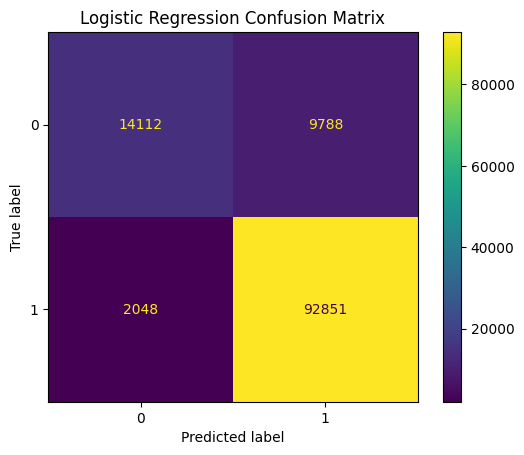

Training RandomForest
RandomForest Accuracy: 0.8998728945529845


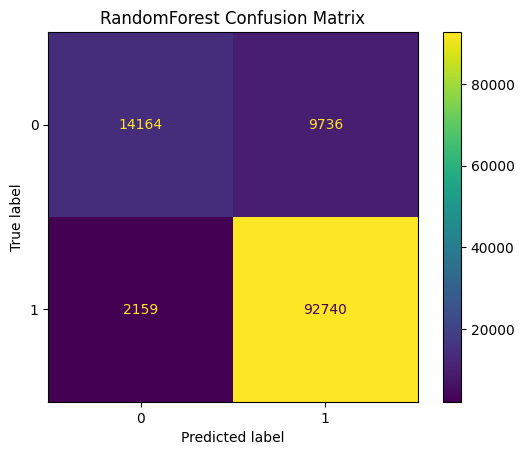

Training Decision Tree
Decision Tree Accuracy: 0.8464886068064545


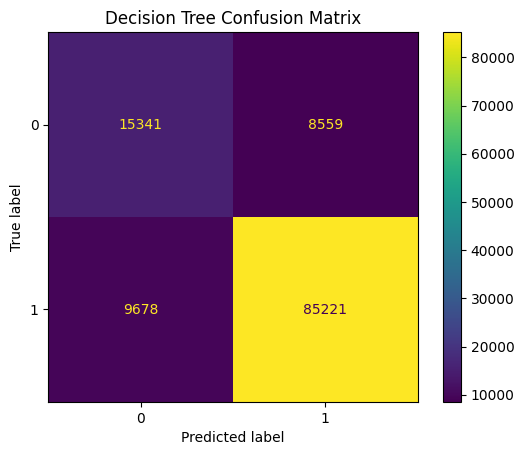

Training K Nearest Neighbors
K Nearest Neighbors Accuracy: 0.889115228242662


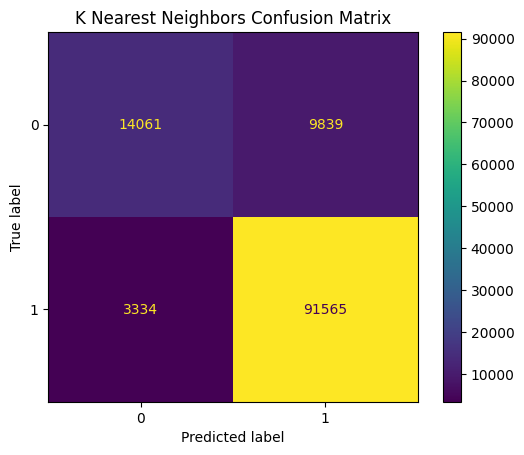

Training Naive Bayes
Naive Bayes Accuracy: 0.8264042626621436


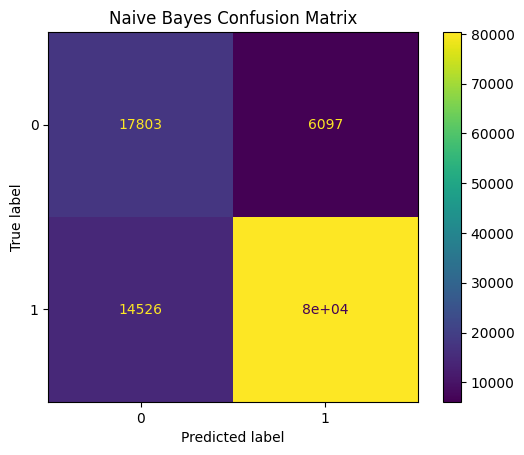


Model performance summary:
Logistic Regression: 0.9004
RandomForest: 0.8999
Decision Tree: 0.8465
K Nearest Neighbors: 0.8891
Naive Bayes: 0.8264


In [368]:
models = {
    "Logistic Regression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

results = {}
for model_name, model in models.items():

    print(f"Training {model_name}")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy}")

    # lets include confusion matrix 
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

print("\nModel performance summary:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


In [369]:
# lets get parameters for random forest (Best Classifier)

rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [371]:
from random import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
}

In [372]:
# tuning randomforest - Hyperparameters

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [ ]:
# define randomsearch

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=234),
    param_distributions = param_grid
)

random_search.fit(x_train, y_train)

print(f"Best Parameters for RandomForest: {random_search.best_estimator_}")

In [ ]:
Best_Model = random_search.best_estimator_
cv_scores = cross_val_score(Best_Model, x_scaled, Y, cv=5)


print(f"cross-validation for RandomForest: {cv_scores}")
print(f"mean cross-validation score: {cv_scores.mean()}")

In [ ]:
y_pred = Best_Model.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))

In [ ]:
import joblib

joblib.dump(Best_Model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("scaler and best model saved successfully")